Quickstart
======

Here is a small example on how to do Bayesian model selection.

Step by step explanation
----------------------------

### Defining a model


To do model selection, we first need some models. A model, in the simplest case,
is just a callable which takes a single `dict` as input and returns a single `dict` as output. The keys of the input dictionary are the parameters of the model, the output
keys denote the summary statistics.
Here, the `dict` is passed as `parameters` and has the entry `x`, which denotes the mean of a Gaussian.
It returns the observed summary statistics `y`, which is just the sampled value.

In [1]:
%matplotlib inline
import os
import tempfile

import scipy.stats as st

import pyabc


# Define a gaussian model

sigma = .5


def model(parameters):
    # sample from a gaussian
    y = st.norm(parameters.x, sigma).rvs()
    # return the sample as dictionary
    return {"y": y}

In [2]:
# that doesn't cut it for me. I need more.

For model selection we usually have more than one model.
These are assembled in a list. We
require a Bayesian prior over the models.
The default is to have a uniform prior over the model classes.
This concludes the model definition.

In [2]:
# We define two models, but they are identical so far
models = [model, model]


# However, our models' priors are not the same.
# Their mean differs.
mu_x_1, mu_x_2 = 0, 1
parameter_priors = [
    pyabc.Distribution(x=pyabc.RV("norm", mu_x_1, sigma)),
    pyabc.Distribution(x=pyabc.RV("norm", mu_x_2, sigma))
]

In [17]:
print(parameter_priors[0])

print(isinstance(parameter_priors[0],dict))

print(parameter_priors[0].keys())

print(parameter_priors[0].values())

print(parameter_priors[0]['x'])

help(parameter_priors[0]['x'])

<Distribution 'x'>
True
dict_keys(['x'])
dict_values([<RV(name=norm, args=(0, 0.5) kwargs={})>])
<RV(name=norm, args=(0, 0.5) kwargs={})>
Help on RV in module pyabc.random_variables object:

class RV(RVBase)
 |  RV(name: str, *args, **kwargs)
 |  
 |  Concrete random variable.
 |  
 |  Parameters
 |  ----------
 |  
 |  name: str
 |      Name of the distribution as in ``scipy.stats``
 |  
 |  args:
 |      Arguments as in ``scipy.stats`` matching the distribution
 |      with name "name".
 |  
 |  kwargs:
 |      Keyword arguments as in ``scipy.stats``
 |      matching the distribution with name "name".
 |  
 |  Method resolution order:
 |      RV
 |      RVBase
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getattr__(self, item)
 |  
 |  __getstate__(self)
 |  
 |  __init__(self, name: str, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  __setstate__(s

### Configuring the ABCSMC run

Having the models defined, we can plug together the `ABCSMC` class.
We need a distance function,
to measure the distance of obtained samples.

In [3]:
# We plug all the ABC options together
abc = pyabc.ABCSMC(
    models, parameter_priors,
    pyabc.PercentileDistance(measures_to_use=["y"]))

In [21]:
abc

### Setting the observed data

Actually measured data can now be passed to the ABCSMC.
This is set via the `new` method, indicating that we start
a new run as opposed to resuming a stored run (see the "resume stored run" example).
Moreover, we have to set the output database where the ABC-SMC run
is logged.

In [4]:
# y_observed is the important piece here: our actual observation.
y_observed = 1
# and we define where to store the results
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))
history = abc.new(db_path, {"y": y_observed})

INFO:History:Start <ABCSMC(id=2, start_time=2021-02-03 10:43:51.177039, end_time=None)>


In [23]:
history

The `new` method returns a history object, whose id identifies the ABC-SMC run in the database.
We're not using this id for now.
But it might be important when you load the stored data or want
to continue an ABC-SMC run in the case of having more than one
ABC-SMC run stored in a single database.

In [5]:
print("ABC-SMC run ID:", history.id)

ABC-SMC run ID: 2


### Running the ABC

We run the `ABCSMC` specifying the epsilon value at which to terminate.
The default epsilon strategy is the `pyabc.epsilon.MedianEpsilon`.
Whatever is reached first, the epsilon or the maximum number allowed populations,
terminates the ABC run. The method returns a `pyabc.storage.History` object, which
can, for example, be queried for the posterior probabilities.

In [6]:
# We run the ABC until either criterion is met
history = abc.run(minimum_epsilon=0.2, max_nr_populations=5)

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.5064041907144253
INFO:ABC:t: 0, eps: 0.5064041907144253.
INFO:ABC:Acceptance rate: 100 / 175 = 5.7143e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.22063407126659326.
INFO:ABC:Acceptance rate: 100 / 385 = 2.5974e-01, ESS=8.0797e+01.
INFO:ABC:t: 2, eps: 0.11761641421944036.
INFO:ABC:Acceptance rate: 100 / 517 = 1.9342e-01, ESS=9.1123e+01.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=2, start_time=2021-02-03 10:43:51.177039, end_time=2021-02-03 10:44:06.689752)>


In [29]:
abc.history.get_nr_particles_per_population()
abc.history.get_all_populations()
history.get_population_strategy()
history.get_population().get_list()
discances = history.get_population().get_for_keys(["distance"])["distance"]

In [30]:
import numpy as np

In [31]:
np.median(discances)

0.06214852519380383

In [32]:
max(discances)

0.1172014524524885

In [38]:
np.median(history.get_population(0).get_for_keys(["distance"])["distance"])

0.22063407126659362

In [47]:
history.get_population_extended()#.get_for_keys(["distance"])["distance"]

,epsilon,samples,m,model_name,p_model,w,particle_id,distance,par_name,par_val,sumstat_name,sumstat_val
0,0.117616,517,1,model,0.616104,0.014702,503,0.004604,x,1.086291,y,1.006410
1,0.117616,517,1,model,0.616104,0.014120,504,0.106510,x,0.884715,y,1.148288
2,0.117616,517,1,model,0.616104,0.014117,505,0.050531,x,1.024936,y,0.929648
3,0.117616,517,1,model,0.616104,0.017294,506,0.007502,x,0.668793,y,0.989556
4,0.117616,517,1,model,0.616104,0.023401,507,0.034513,x,1.354067,y,0.951949
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.117616,517,0,model,0.383896,0.044418,598,0.069348,x,-0.006256,y,0.903451
96,0.117616,517,0,model,0.383896,0.014665,599,0.110846,x,1.017686,y,0.845676
97,0.117616,517,0,model,0.383896,0.013145,600,0.050287,x,1.092297,y,0.929988
98,0.117616,517,0,model,0.383896,0.008497,601,0.107971,x,1.323748,y,0.849679


Note that the history object is also always accessible from the abcsmc object:

In [48]:
history is abc.history

True

The `pyabc.storage.History>` object can, for example,
be queried for the posterior probabilities in the populations:

In [49]:
# Evaluate the model probabililties
model_probabilities = history.get_model_probabilities()
model_probabilities

m,0,1
t,,
0,0.270000,0.730000
1,0.374531,0.625469
2,0.383896,0.616104


And now, let's visualize the results:

<AxesSubplot:title={'center':'Model probabilities'}, xlabel='Population index', ylabel='Probability'>

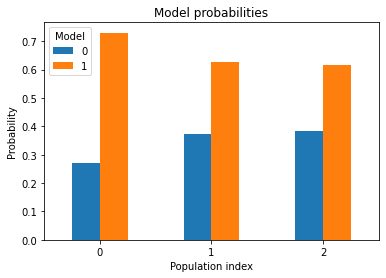

In [50]:
pyabc.visualization.plot_model_probabilities(history)

So model 1 is the more probable one. Which is expected as it was centered at 1 and the observed data was also 1, whereas model 0 was centered at 0, which is farther away from the observed data. 